In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import sys
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import TimeDistributed,Bidirectional,GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM,GRU,SimpleRNN,BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as sp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

2024-04-30 16:22:30.746868: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 16:22:30.748076: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:22:30.773424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:22:30.773933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

import numpy as np
import os
from tensorflow import keras
#import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [3]:
data_path = "/home/muhlabws4/Masaüstü/tkd_data/orj"

In [4]:
class_folders = os.listdir(data_path)

In [5]:
images = []
labels = []

In [6]:
for i , class_name in enumerate(class_folders):
    class_folder_path = os.path.join(data_path, class_name)
    class_images = os.listdir(class_folder_path)
    
    for img_name in class_images:
        img_path = os.path.join(class_folder_path, img_name)
        img = load_img(img_path, target_size=(180,320))
        img_array = img_to_array(img) /255.0
        images.append(img_array)
        labels.append(class_name)

In [7]:
X = np.array(images)
y = np.array(labels)

In [8]:
label_encoder = LabelEncoder()
y_encoder = label_encoder.fit_transform(y)

In [9]:
X_shuf, y_shuf = X, y_encoder

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(X_shuf, y_shuf, test_size=0.2, random_state=42)

In [11]:
print(X.shape)
print(y.shape)
print(y_encoder.shape)

(407, 180, 320, 3)
(407,)
(407,)


In [12]:
#class_names = ['head_sb','head_sesor', 'other','punch','rotation']
class_names = ['head', 'other','punch']

In [13]:
img_height=180
img_width=320
output=3

In [14]:
checkpoint_path = "best_modelvgg16.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [15]:
def pretrained_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape = (img_height,img_width,3))
    base_model.trainable = False ## Not trainable weights
    flatten_layer = Flatten()
    dense_layer_1 = Dense(256, activation='relu')
    prediction_layer = Dense(output, activation='softmax')
    
    model = Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      #dense_layer_2,
      prediction_layer
      ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    return model

In [16]:
def cross_validation(model, X, y, n_splits=5, epochs=5, batch_size=32):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #result = []
    for train_inx, val_inx in kfold.split(X):
        X_train, X_val = X[train_inx], X[val_inx]
        y_train, y_val = y[train_inx], y[val_inx]
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        a = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, class_weight={0:7,1:10,2:22},callbacks=[checkpoint])
        #model.fit(X_train, y_train, epochs=epochs)
        #result.append(a.history['val_accuracy'])
        
    #return result

In [17]:
def gosterTrain(index):
    plt.figure(figsize=(15,2))
    plt.imshow(train_images[index])
    plt.title(class_names[train_labels[index]])

In [18]:
def gosterTest(index):
    plt.figure(figsize=(15,2))
    plt.imshow(test_images[index])
    plt.title(class_names[test_labels[index]])

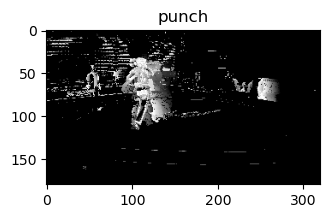

In [19]:
gosterTrain(10)

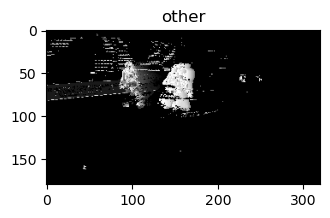

In [20]:
gosterTest(7)

In [21]:
model = pretrained_vgg16()
result = cross_validation(model, train_images, train_labels, n_splits=4, epochs=15, batch_size=32)

2024-04-30 16:23:04.018095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 16:23:04.020784: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/15
8/8 - 8s - loss: 44.7382 - accuracy: 0.5062 - 8s/epoch - 1s/step
Epoch 2/15
8/8 - 8s - loss: 17.9525 - accuracy: 0.5638 - 8s/epoch - 974ms/step
Epoch 3/15
8/8 - 8s - loss: 13.0193 - accuracy: 0.6173 - 8s/epoch - 963ms/step
Epoch 4/15
8/8 - 8s - loss: 6.9155 - accuracy: 0.7160 - 8s/epoch - 968ms/step
Epoch 5/15
8/8 - 8s - loss: 5.4791 - accuracy: 0.7901 - 8s/epoch - 1s/step
Epoch 6/15
8/8 - 9s - loss: 4.6401 - accuracy: 0.8189 - 9s/epoch - 1s/step
Epoch 7/15
8/8 - 9s - loss: 4.1006 - accuracy: 0.8436 - 9s/epoch - 1s/step
Epoch 8/15
8/8 - 9s - loss: 3.6235 - accuracy: 0.8848 - 9s/epoch - 1s/step
Epoch 9/15
8/8 - 9s - loss: 3.1847 - accuracy: 0.8807 - 9s/epoch - 1s/step
Epoch 10/15
8/8 - 9s - loss: 2.7358 - accuracy: 0.9095 - 9s/epoch - 1s/step
Epoch 11/15
8/8 - 9s - loss: 2.5549 - accuracy: 0.9342 - 9s/epoch - 1s/step
Epoch 12/15
8/8 - 9s - loss: 2.8493 - accuracy: 0.9053 - 9s/epoch - 1s/step
Epoch 13/15
8/8 - 9s

8/8 - 9s - loss: 0.2019 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 8/15
8/8 - 9s - loss: 0.1925 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 9/15
8/8 - 9s - loss: 0.1751 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 10/15
8/8 - 9s - loss: 0.1573 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 11/15
8/8 - 9s - loss: 0.1534 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 12/15
8/8 - 9s - loss: 0.1402 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 13/15
8/8 - 9s - loss: 0.1320 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 14/15
8/8 - 9s - loss: 0.1279 - accuracy: 1.0000 - 9s/epoch - 1s/step
Epoch 15/15
8/8 - 9s - loss: 0.1133 - accuracy: 1.0000 - 9s/epoch - 1s/step


In [22]:
model.evaluate(test_images, test_labels)

3/3 [==============================] - 3s 812ms/step - loss: 1.3448 - accuracy: 0.6463


[1.3447810411453247, 0.6463414430618286]

In [23]:
tahminler = model.predict(test_images)

3/3 [==============================] - 3s 831ms/step


In [24]:
model.save(checkpoint_path)

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
y_pred_classes = np.argmax(tahminler,axis=1)

In [26]:
tahminler[:7]

array([[8.6162016e-02, 8.1808966e-01, 9.5748365e-02],
       [1.1479693e-02, 3.8938266e-05, 9.8848140e-01],
       [9.7598364e-05, 6.5311208e-02, 9.3459117e-01],
       [2.8193355e-01, 9.4898632e-03, 7.0857668e-01],
       [1.2962705e-02, 9.2811400e-01, 5.8923341e-02],
       [8.0520258e-04, 1.1810527e-07, 9.9919468e-01],
       [3.2688500e-04, 2.9504963e-04, 9.9937797e-01]], dtype=float32)

In [27]:
np.argmax(tahminler[9])

2

In [28]:
test_labels

array([0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1,
       2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2,
       2, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2,
       1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1])

In [29]:
y_pred_classes

array([1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2,
       1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1])

In [30]:
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.32      0.41        19
           1       0.69      0.45      0.55        20
           2       0.64      0.88      0.75        43

    accuracy                           0.65        82
   macro avg       0.65      0.55      0.57        82
weighted avg       0.65      0.65      0.62        82



In [33]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

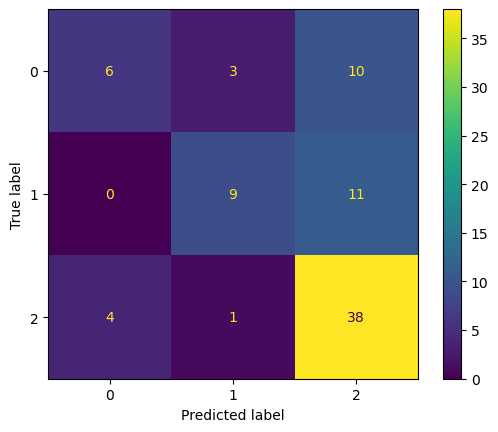

In [34]:
cm_display.plot()
plt.show() 

In [35]:
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

In [36]:
print(conf_matrix)

[[ 6  3 10]
 [ 0  9 11]
 [ 4  1 38]]
